In [1]:
import pandas as pd
import math
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('raw/in7days.csv')

In [4]:
df.head()

,user_id,charge_start_date,singup_date,window_date
0,37698,2023-01-06 20:26:51,2023-01-06,2023-01-13
1,37734,2023-01-07 12:51:17,2023-01-07,2023-01-14
2,37622,2023-01-07 19:23:34,2023-01-04,2023-01-11
3,37724,2023-01-07 18:17:53,2023-01-07,2023-01-14
4,37622,2023-01-07 20:02:32,2023-01-04,2023-01-11


In [5]:
df['user_id'] = df['user_id'].astype('Int64')
df['datetime'] = pd.to_datetime(df['charge_start_date'])
df = df.drop('charge_start_date', axis=1)

In [6]:
# (1) date 칼럼 추가, usage interval에 맞춰 날짜를 truncate
df['date'] = pd.to_datetime(df['datetime']).dt.date
df = df.drop('datetime', axis=1)

In [7]:
# 주차별 코호트
df['date'] = df['date'] - pd.to_timedelta(pd.to_datetime(df['date']).dt.dayofweek, unit='d')

# (2) 유저별로 이벤트를 처음 수행한 날짜를 계산
df['cohort'] = df.groupby('user_id')['date'].transform('min')

/var/folders/gl/pxwk91q159q_s409z0y7363r0000gn/T/ipykernel_41517/3719518536.py:2: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  df['date'] = df['date'] - pd.to_timedelta(pd.to_datetime(df['date']).dt.dayofweek, unit='d')


In [8]:
# (3) cohort마다 date를 기준으로 몇 명의 유저가 이벤트를 발생시켰는지 집계
df_cohort = \
    df.groupby(['cohort', 'date']) \
        .agg(cnt=('user_id', 'nunique')) \
        .reset_index(drop=False)

In [9]:
    # (4) date와 cohort 사이에 몇 일이 있는지 계산
df_cohort['diff'] = \
    [math.floor(x) for x in ((df_cohort['date'] - df_cohort['cohort']).dt.days) / 7]

In [10]:
    # (5) cohort를 index, diff를 column으로 하는 pivot 테이블을 만듦
cohort_pivot = \
    df_cohort.pivot_table(
        index='cohort',
        columns='diff',
        values='cnt')

In [11]:
    # (6) cohort별로 유저 수를 셈
cohort_size = df.groupby('cohort').agg(cnt=('user_id', 'nunique'))['cnt']

In [12]:
# (7) cohort_pivot dataframe을 cohort_size로 나눠 비율 계산
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [13]:
print(retention_matrix)

diff          0         1
cohort                   
2023-01-02  1.0  0.400000
2023-01-09  1.0  0.266667
2023-01-16  1.0  0.318182
2023-01-23  1.0  0.039216
2023-01-30  1.0  0.238095
2023-02-06  1.0  0.214286
2023-02-13  1.0  0.057692
2023-02-20  1.0  0.105263
2023-02-27  1.0  0.200000
2023-03-06  1.0  0.277778
2023-03-13  1.0  0.157143
2023-03-20  1.0  0.148936
2023-03-27  1.0  0.078947
2023-04-03  1.0       NaN


In [14]:
retention_avg = retention_matrix.mean(axis=0) * 100

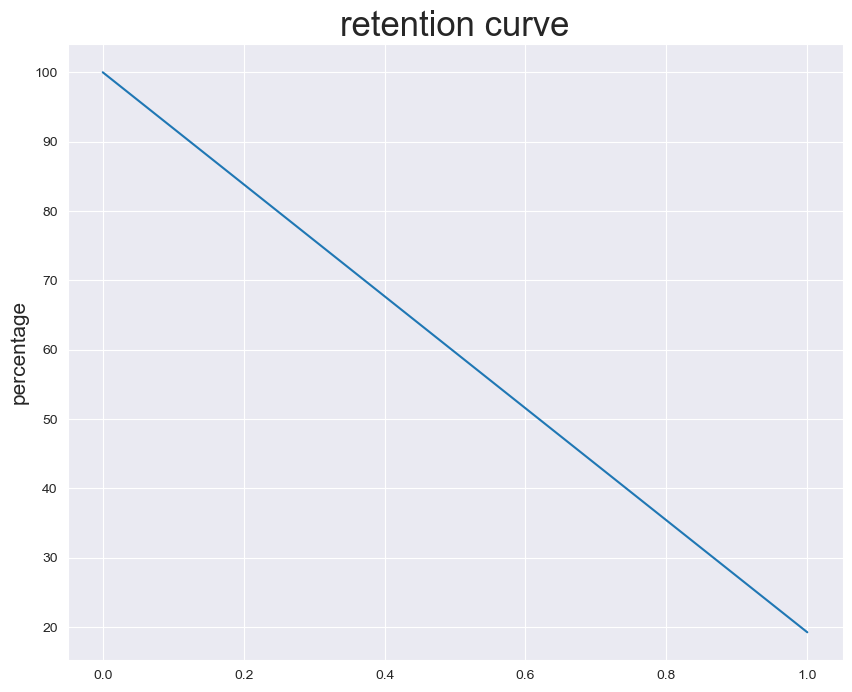

In [15]:
# retention curve 시각화
plt.figure(figsize=(10, 8))

plt.plot(range(0, len(retention_avg)), retention_avg)
plt.title('retention curve', fontsize=25)
plt.ylabel('percentage', fontsize=15)

plt.show()

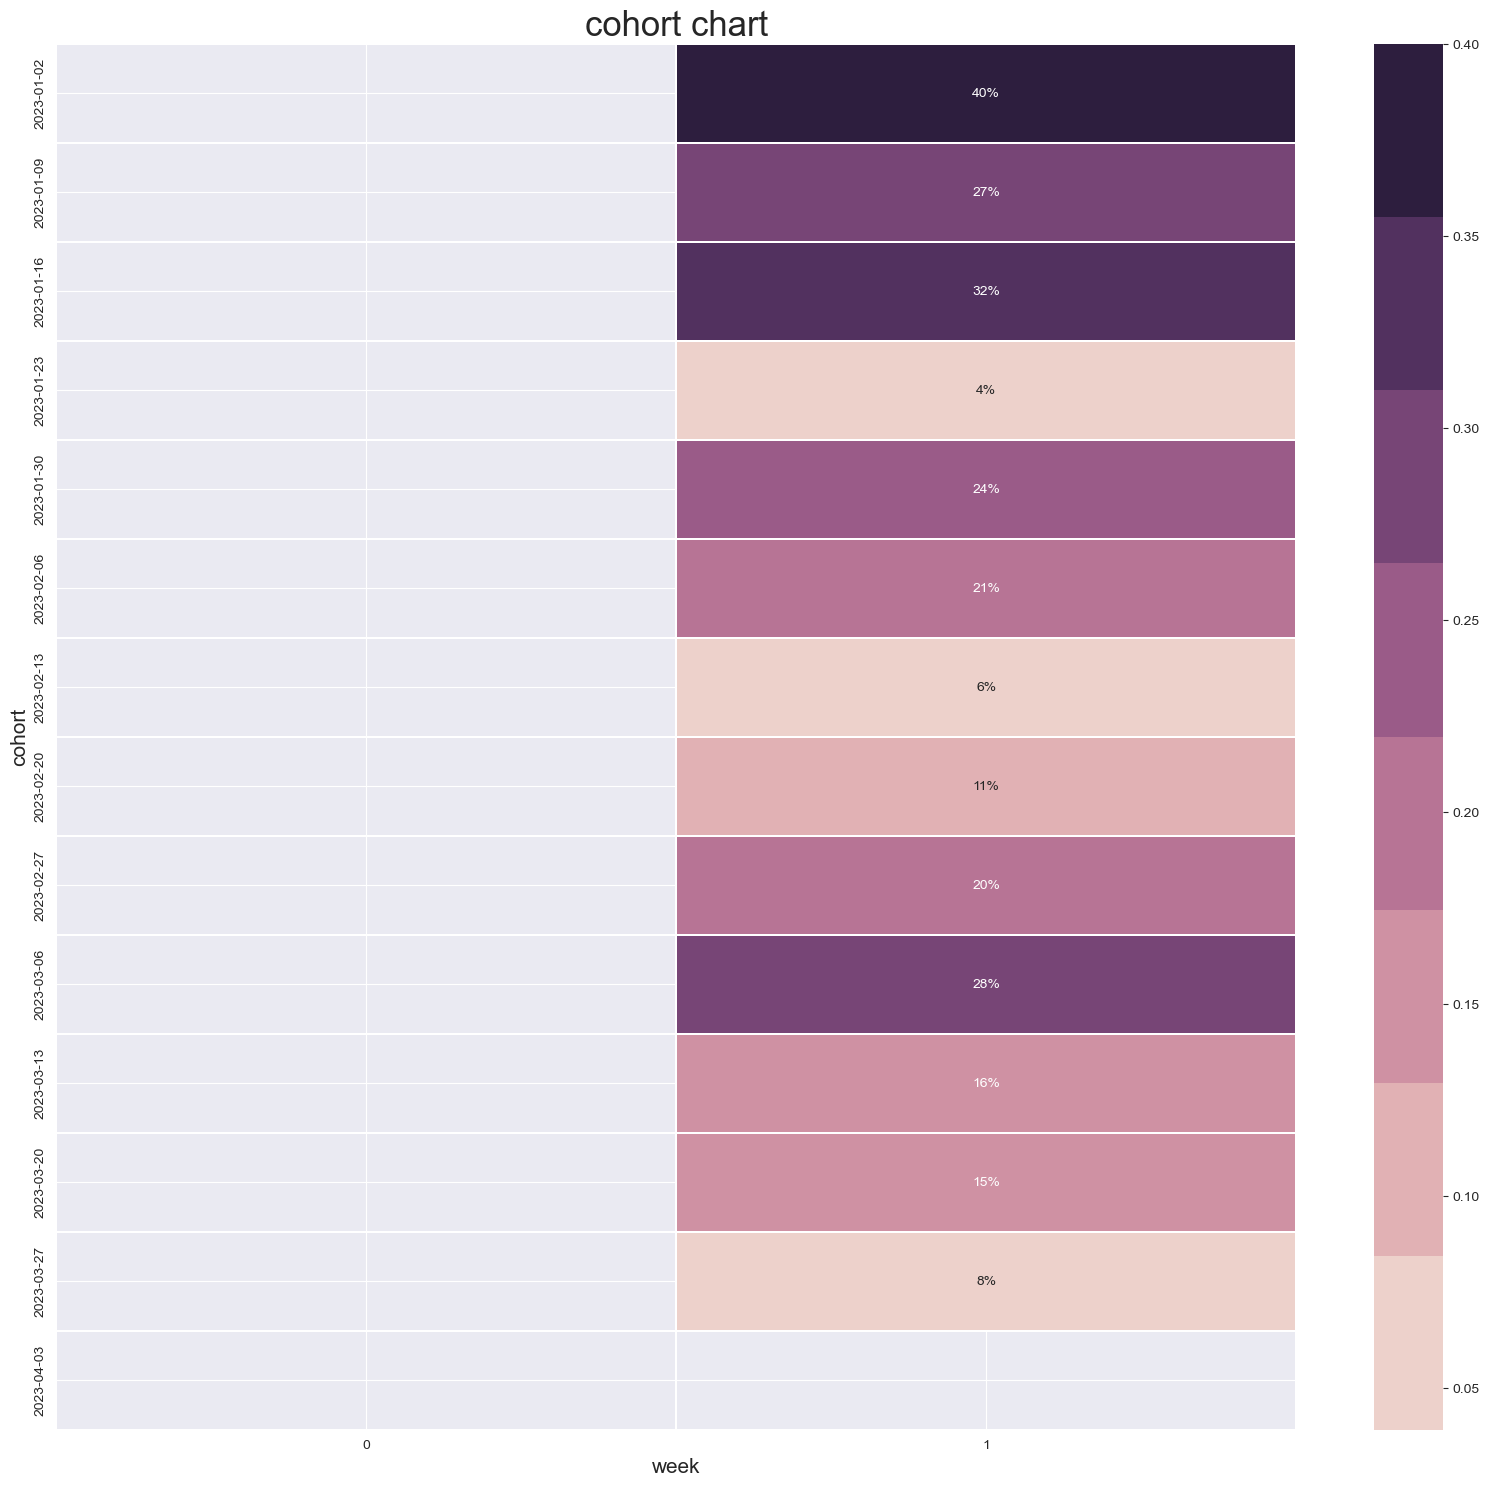

In [16]:
# 그래프에 의미없는 값은 보여주지 않기 위해 안 나와도 되는 값의 위치 표시
mask = retention_matrix.isnull()
mask.iloc[:, 0] = True

# cohort chart 시각화
plt.figure(figsize=(20, 18))

sns.heatmap(
    retention_matrix,
    mask=mask,
    annot=True,
    fmt='.0%',
    cmap=sns.cubehelix_palette(8),
    linewidths=.1
)

plt.title('cohort chart', fontsize=25)
plt.xlabel('week', fontsize=15)
plt.ylabel('cohort', fontsize=15)

plt.show()